### Decoding profile

In [1]:
from pathlib import Path
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import numpy as np
import matplotlib.pyplot as plt
from palettable.scientific.sequential import Nuuk_3 as ColMap
from src.config import SUBJECTS, SESSION, N_LAYER
from src.stats import Bootstrap, fdr_correction
plt.style.use(os.path.join(module_path, "src", "default.mplstyle"))

DIR_DATA = "/data/pt_01880/Experiment1_ODC/paper/decoding"
FILTER_SIZE = "none"

# set
SESS = "VASO"

In [2]:
def get_profile(sess, day):
    y = np.zeros((N_LAYER, len(SUBJECTS)))
    for i, subj in enumerate(SUBJECTS):
        path = Path(DIR_DATA) / subj / f"{sess}{SESSION[subj][sess][day]}"
        file = path / f"bandpass_{FILTER_SIZE}" / "accuracy.csv"
        data = np.genfromtxt(file, delimiter=',')
        for j in range(N_LAYER):
            y[j, i] = np.mean(data[j, :] * 100)
    return y

In [3]:
x = np.linspace(0, 1, N_LAYER)
y1 = get_profile(SESS, 0)
y2 = get_profile(SESS, 1)
y3 = np.append(y1, y2, axis=1)

ci_low = []
ci_high = []
p_adj = []
for i in range(N_LAYER):
    boot = Bootstrap(y3[i,:])
    low, high = boot.confidence_interval()
    ci_low.append(low)
    ci_high.append(high)
    p_adj.append(boot.p_value())
p_adj = fdr_correction(p_adj)

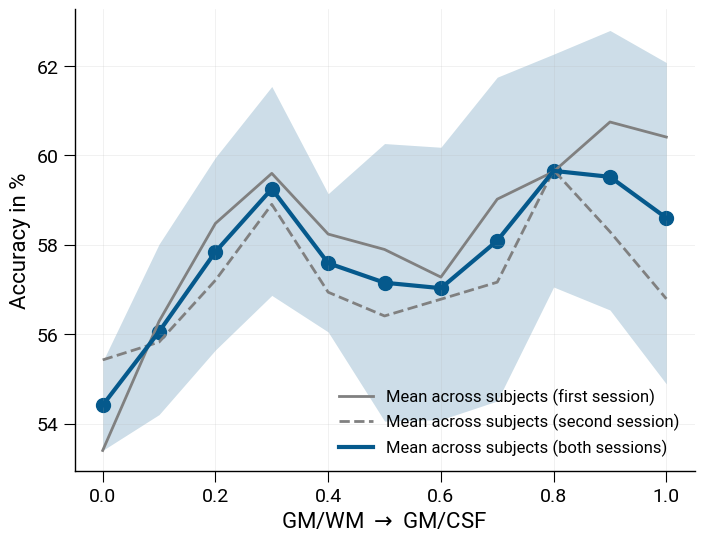

In [4]:
fig, ax = plt.subplots()
color = ColMap.hex_colors
ax.plot(x, np.mean(y1, axis=1), color="gray", linestyle="-", label="Mean across subjects (first session)")
ax.plot(x, np.mean(y2, axis=1), color="gray", linestyle="--", label="Mean across subjects (second session)")
ax.plot(x, np.mean(y3, axis=1), color=color[0], linestyle="-", label="Mean across subjects (both sessions)", lw=3)
ax.scatter(x[p_adj[i]<0.05],np.mean(y3, axis=1)[p_adj[i]<0.05], color=color[0], s=100)
ax.fill_between(x, ci_low, ci_high, color=color[0], alpha=0.2, lw=0)
ax.set_xlabel(r"GM/WM $\rightarrow$ GM/CSF")
ax.set_ylabel("Accuracy in %")
ax.legend(loc="lower right")
file_out = f"/data/pt_01880/decoding_{SESS}.svg"
fig.savefig(file_out, dpi=300, bbox_inches="tight", transparent=True, format="svg")